In [1]:
!pip install -q transformers
!pip install -q tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.5 MB/s eta 0:00:00


In [2]:
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
from transformers import AdamW, RobertaForSequenceClassification, get_linear_schedule_with_warmup

In [3]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import sys
import pickle
import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import unicodedata
from tqdm import tqdm
import string
import itertools
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data import Dataset
from torchtext.data.utils import get_tokenizer
from torch.optim import Adam
#from keras_preprocessing.sequence import pad_sequences
torch.manual_seed(10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# !pip install -q contractions
# import contractions

In [4]:
# import EarlyStopping  --> #https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [4]:
# Load clean dataframes
data_filepath_train = '/content/drive/MyDrive/Colab Notebooks/Kaggle comps/Goodreads Books Review Rating Prediction/data/train_df_clean.pkl'
with open(data_filepath_train, 'rb') as f:
  train_df = pickle.load(f)

data_filepath_val = '/content/drive/MyDrive/Colab Notebooks/Kaggle comps/Goodreads Books Review Rating Prediction/data/valdf_clean.pkl'
with open(data_filepath_val, 'rb') as f:
  val_df = pickle.load(f)  

data_filepath_test = '/content/drive/MyDrive/Colab Notebooks/Kaggle comps/Goodreads Books Review Rating Prediction/data/testdf_clean.pkl'
with open(data_filepath_test, 'rb') as f:
  test_df = pickle.load(f)

train_df.head()  

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

target_classes = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness','surprise']

# Load 
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle comps/Goodreads Books Review Rating Prediction/data/goodreads_train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle comps/Goodreads Books Review Rating Prediction/data/goodreads_test.csv')


# # Cleaning steps
# # Convert any negative votes values to 0
# df['n_votes'] = df['n_votes'].apply(lambda x: 0 if x < 0 else x)

# # Do the same for test set
# test_df['n_votes'] = test_df['n_votes'].apply(lambda x: 0 if x < 0 else x)

# # Convert any negative votes values to 0
# df['n_comments'] = df['n_comments'].apply(lambda x: 0 if x<0 else x)

# # Do the same for test set
# test_df['n_comments'] = test_df['n_comments'].apply(lambda x: 0 if x<0 else x)

# # Split data into train and val
# train_df, val_df = train_test_split(df, train_size=0.8, random_state=10, stratify=df['rating'])

# # Text cleaning steps
# def clean_review(doc):

#   punct = string.punctuation
#   punct = punct.replace("!","").replace(",","").replace(".","").replace("?","").replace("'","").replace("@","")
#   table = str.maketrans("","", punct)
  
#   text = doc.lower().strip()   #lower-case and strip spaces at start and beginning
#   text = contractions.fix(text)  # fixing contractions

#   text =  re.sub("https*\S+", " ", text)  #remove any weblinks
#   text =  re.sub("\S+@\S+", " ", text)  #remove any emails  
#   text = re.sub(r' +'," ",text) # multiple spaces
  
#   # remove multiple punctuations
#   text = re.sub(r'\?+',"?",text)
#   text = re.sub(r'!+',"!",text)
#   text = re.sub(r'\.+',".",text)
#   text = re.sub(r'\'+',"'",text)
#   text = re.sub(r',+',",",text)
#   text = re.sub(r'@+',"@",text)

#   # normalize unicode characters
#   text = unicodedata.normalize('NFD',text).encode('ascii','ignore')
#   text = text.decode('UTF-8')

  
#   #strip extra spaces
#   text = text.strip().split()
#   #text = word_tokenize(text)   #tokenize
#   text = [tok.translate(table) for tok in text]   #remove punct
#   text = [tok.strip() for tok in text if not tok.isdigit()]  #remove no.s 
 
  
#   return ' '.join(text).strip()


# # Add clean_review column for boht train_df and val_df
# train_df['clean_review_text'] =  train_df['review_text'].apply(lambda x: clean_review(x))
# val_df['clean_review_text'] =  val_df['review_text'].apply(lambda x: clean_review(x))
# test_df['clean_review_text'] =  test_df['review_text'].apply(lambda x: clean_review(x))

# # Reset index
# train_df.reset_index(inplace = True,drop = True)
# val_df.reset_index(inplace = True,drop = True)
# test_df.reset_index(inplace = True,drop = True)

In [6]:
class ReviewData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, training):
      
      self.tokenizer = tokenizer
      self.data = dataframe
      self.review_id = dataframe.review_id
      self.text = dataframe.review_text
      self.max_len = max_len
      # self.num_feats = dataframe.iloc[:,16:23].reset_index(drop=True)

      self.training = training
      if self.training:
        self.targets = dataframe.rating
          

    def __len__(self):
        return len(self.text)

    def __reviewid__(self):
        return self.review_id   

    def __getitem__(self, index):
      text = str(self.text[index])
      # numfeats = self.num_feats[index].astype(float)
      inputs = self.tokenizer.encode_plus(
          text,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          padding='max_length',
          return_token_type_ids=True,
          truncation=True,
          return_attention_mask=True,
       )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']
      token_type_ids = inputs["token_type_ids"]

      if self.training:
        
        return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
          'targets': torch.tensor(self.targets[index], dtype=torch.long),
          #  'num_feats': torch.tensor(numfeats, dtype=torch.float32)
          }

      else:

        return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
          #  'num_feats': torch.tensor(numfeats, dtype=torch.float32)
          }





In [8]:
# Setting up the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base',truncation=True, do_lower_case=True)

In [17]:
# Inspecting seq len
lens = [len(x) for x in list(train_df.review_text.values)]
pd.Series(lens).describe()

count    720000.000000
mean        662.650561
std         782.185339
min           0.000000
25%         136.000000
50%         375.000000
75%         910.000000
max       12662.000000
dtype: float64

In [9]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512 
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
LEARNING_RATE = 1e-5
n_classes = 6

training_set = ReviewData(train_df, tokenizer, MAX_LEN, training=True)
validation_set = ReviewData(val_df, tokenizer, MAX_LEN, training=True)
testing_set = ReviewData(test_df, tokenizer, MAX_LEN, training=False)

In [10]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }


valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }


test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

train_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(validation_set, **valid_params)
test_loader = DataLoader(testing_set, **test_params)

#class_weights = {0:4.8406 , 1:5.2232 , 2:2.0653, 3:0.7938, 4:0.4782, 5:0.5660}
# class_weights = torch.tensor([4.8406, 5.2232, 2.0653, 0.7938, 0.4782, 0.5660])

In [11]:
class RobertaClass(torch.nn.Module):
    def __init__(self,n_classes=6):
        super(RobertaClass, self).__init__()
        self.n_classes = n_classes
        self.l1 = RobertaModel.from_pretrained("roberta-base",output_hidden_states=True, return_dict=True)
        self.l1.train()
        self.pre_classifier = torch.nn.Linear(768, 512)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(512, self.n_classes)
        

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        output = output.last_hidden_state    # Last hidden layer
        output = torch.mean(output, dim=1)   # Taking the average of all token vectors.
        output = self.pre_classifier(output)
        output = torch.nn.ReLU()(output)
        output = self.dropout(output)
        output = self.classifier(output)
        return output

In [ ]:
model = RobertaClass()
model = nn.DataParallel(model)
model.to(device)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DataParallel(
  (module): RobertaClass(
    (l1): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_features=768, out_featu

In [ ]:
for i,D in enumerate(train_loader):
  a = D['ids']
  b = D['mask']
  c = D['token_type_ids']
  d = D['targets']
 
  print(a.shape, b.shape, c.shape, d.shape)
  with torch.no_grad():
    x = model(input_ids=a, attention_mask=b, token_type_ids=c)
    print(x.shape)
  break;

torch.Size([32, 512]) torch.Size([32, 512]) torch.Size([32, 512]) torch.Size([32])
torch.Size([32, 6])


In [ ]:
# Creating the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, threshold=1e-04, cooldown=0, min_lr=0, eps=1e-10)


In [ ]:
# https://towardsdatascience.com/pytorch-training-tricks-and-tips-a8808ebf746c
scaler = torch.cuda.amp.GradScaler()
autocast = torch.autocast('cuda')

# Train function
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader,model_path,epochs=10, patience=3):
    
    history = {} # Collects per-epoch loss and acc 
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=model_path)
    
    # Training 

    for epoch in range(1, epochs+1):

      model.train()
      train_loss = 0.0
      num_train_correct  = 0
      num_train_examples = 0
      
      for _, data in tqdm(enumerate(train_loader), total = len(train_loader)):     
     
        # clearing the Gradients of the model parameters
        optimizer.zero_grad(set_to_none=True)

        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        Y = data['targets'].to(device, dtype = torch.long)
          
        # Using 16 bit precision
        with autocast:
          # Forward Pass
          Y_preds = model(ids, mask, token_type_ids)
          loss = loss_fn(Y_preds, Y)  # computing training loss
        
          scaler.scale(loss).backward()   # computing the updated weights of all the model parameters
          scaler.step(optimizer)  # Update Optimizer
          scaler.update()

          train_loss += loss.data.item() * ids.shape[0]
          num_train_correct += (torch.max(Y_preds, 1)[1] == Y).sum().item()     
          num_train_examples += ids.shape[0]    

      #scheduler.step()       
      train_acc = num_train_correct / num_train_examples
      train_loss = train_loss / len(train_loader)        
            
    # Evaluate on val set
      model.eval()
      val_loss = 0.0
      num_val_correct = 0
      num_val_examples = 0

      for _, data in tqdm(enumerate(val_loader), total=len(val_loader)):
        with torch.no_grad():

          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          Y = data['targets'].to(device, dtype = torch.long)

          Y_preds = model(ids, mask, token_type_ids)
          loss = loss_fn(Y_preds, Y)  # computing val loss

          val_loss += loss.data.item() * ids.shape[0]
          num_val_correct += (torch.max(Y_preds, 1)[1] == Y).sum().item()     
          num_val_examples += ids.shape[0]    

      val_acc  = num_val_correct / num_val_examples
      val_loss = val_loss / len(val_loader)
      scheduler.step(val_loss)

      print('Epoch %2d/%2d, train loss: %5.3f, train acc: %5.3f, val loss: %5.3f, val acc: %5.3f' % \
          (epoch, epochs, train_loss, train_acc, val_loss, val_acc))
        
      history['loss'].append(train_loss)
      history['val_loss'].append(val_loss)
      history['acc'].append(train_acc)
      history['val_acc'].append(val_acc)
        
      
      # Early stopping will check if validation loss has decreased
      early_stopping(val_loss,model)
      
      if early_stopping.early_stop:
            print("Early stopping")
            break

    #Load the last checkpoint with the best model
    model.load_state_dict(torch.load(model_path))
    
    return history

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle comps/Goodreads Books Review Rating Prediction/data/rob_finetuned.pt'
epochs=30
history = TrainModel(model, loss_fn, optimizer, train_loader, val_loader,model_path=model_path,epochs=epochs, patience=5)

100%|██████████| 5625/5625 [23:29<00:00,  3.99it/s]


Epoch  1/30, train loss: 38.646, train acc: 0.557, val loss: 38.123, val acc: 0.566
Validation loss decreased (inf --> 38.123134).  Saving model ...


100%|██████████| 5625/5625 [23:24<00:00,  4.00it/s]


Epoch  2/30, train loss: 38.783, train acc: 0.556, val loss: 39.106, val acc: 0.554
EarlyStopping counter: 1 out of 5


100%|██████████| 5625/5625 [23:27<00:00,  4.00it/s]


Epoch  3/30, train loss: 38.919, train acc: 0.553, val loss: 38.670, val acc: 0.560
EarlyStopping counter: 2 out of 5


100%|██████████| 5625/5625 [23:34<00:00,  3.98it/s]


Epoch  4/30, train loss: 38.798, train acc: 0.555, val loss: 38.475, val acc: 0.562
EarlyStopping counter: 3 out of 5


100%|██████████| 5625/5625 [23:30<00:00,  3.99it/s]


Epoch  5/30, train loss: 38.616, train acc: 0.559, val loss: 38.863, val acc: 0.557
EarlyStopping counter: 4 out of 5


100%|██████████| 5625/5625 [23:21<00:00,  4.01it/s]


Epoch  6/30, train loss: 38.029, train acc: 0.570, val loss: 38.432, val acc: 0.566
EarlyStopping counter: 5 out of 5
Early stopping


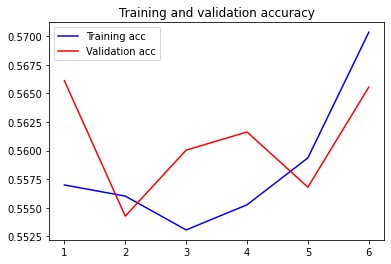

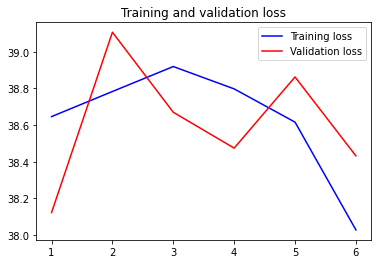

In [ ]:
def plot_history(history):
  acc = history['acc']
  val_acc = history['val_acc']
  loss = history['loss']
  val_loss = history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()


plot_history(history)

In [12]:
model = RobertaClass().to(device)
model = nn.DataParallel(model)
model_path = '/content/drive/MyDrive/Colab Notebooks/Kaggle comps/Goodreads Books Review Rating Prediction/data/rob_finetuned.pt'
model.load_state_dict(torch.load(model_path, map_location=device))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [13]:
# Make predictions
def MakePredictions(model, loader):
  with torch.no_grad():
    Y_preds = []
    for data in tqdm(loader, total=len(loader)):
      
      ids = data['ids']
      mask = data['mask']
      token_type_ids = data['token_type_ids']
        
      preds = model(ids, mask, token_type_ids)
      Y_preds.append(preds)
    
    gc.collect()
    Y_preds = torch.cat(Y_preds)

    return F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()

Y_preds = MakePredictions(model, test_loader)



100%|██████████| 14939/14939 [4:20:50<00:00,  1.05s/it]


In [14]:
test_reviews = list(test_df.review_id.values)

#  Build a dataframe and save as .csv
preds = []
for review, pred in zip(test_reviews, Y_preds):
  preds.append((review,pred))

pred_df = pd.DataFrame(preds, columns=['review_id','rating'])
pred_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle comps/Goodreads Books Review Rating Prediction/data/preds/rob_finetuned.csv', index=False)